In [1]:
import numpy as np
import pandas as pd
import os
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir("./Sudan cities/")

In [3]:
cities = pd.read_excel("Sudan_city_regions_2023-10-09.xlsx")

In [4]:
edges = pd.read_excel("Sudan_states_edgelist_2023-10-12.xlsx")
edges['val'] = edges['val_delta'].fillna(0).apply(lambda x: 0 if x<0 else x)

In [5]:
outmigration = edges.groupby(['from','date_later']).agg({'val':'sum'}).reset_index()

In [6]:
inmigration = edges.groupby(['to','date_later']).agg({'val':'sum'}).reset_index()

In [7]:
sentiment = pd.read_csv("sentiment.csv")

In [8]:
emotions = pd.read_csv("emotions.csv")

In [9]:
predictors = sentiment.merge(emotions, on=['tweet_id', 'date'], how='outer', suffixes=('_sent', '_emo'))
predictors['date'] = pd.to_datetime(predictors['date'])
predictors = predictors.loc[predictors['language']!='tr',:]

In [10]:
set(cities['name_translated']).intersection(predictors['city'])

{'Kaduqli', 'Zalingei', 'أم بدر', 'الخرطوم', 'بورام', 'جيدات', 'سوكي', 'نيالا'}

In [11]:
cities.rename({'name_translated':'city'}, axis=1, inplace=True)

In [12]:
predictors = predictors.merge(cities.loc[:,['city', 'Sudan_regions']], how='left', on='city')
predictors['Sudan_regions'].isnull().value_counts()

Sudan_regions
True     52194
False    32537
Name: count, dtype: int64

In [13]:
predictors = predictors.loc[predictors['Sudan_regions'].notnull(), :]

In [14]:
date_trans_dict = {}
dates = [date(2023, 4, 14)] + [x.date() for x in sorted(edges['date_later'].unique())]
for d1, d2 in list(zip(dates[:-1], dates[1:])):
    target_date = d1 + timedelta(days=1)
    while target_date<=d2:
        date_trans_dict[target_date] = d2
        target_date += timedelta(days=1)

In [15]:
predictors['date_later'] = predictors['date'].map(date_trans_dict).fillna('2023-04-14')

<Axes: xlabel='date', ylabel='date_later'>

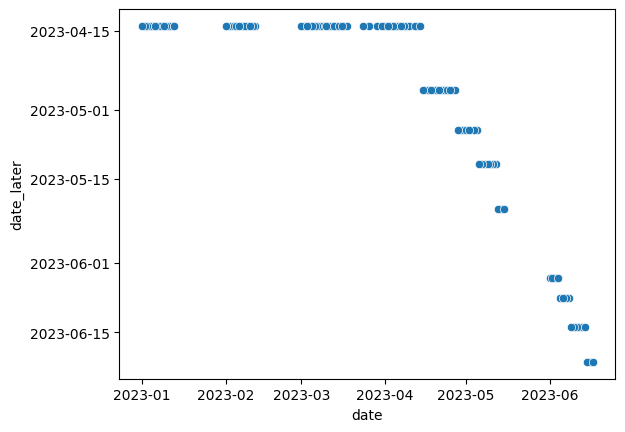

In [16]:
date_coversion = predictors.groupby('date_later')['date'].value_counts().reset_index()
sns.scatterplot(y='date_later', x='date', data=date_coversion)

In [17]:
nr_tweets = predictors.groupby(['Sudan_regions','date_later']).size().reset_index(name='nr_tweets')

In [18]:
sent_vars = ['sentiment_comboLex', 'sentiment_SVM', 'sentiment_multiBERT']
emo_vars = ['anger_NaiveBayes', 'fear_NaiveBayes', 'sadness_NaiveBayes', 'disgust_NaiveBayes',
            'joy_NaiveBayes', 'anger-disgust_NaiveBayes', 'anger_Lex', 'fear_Lex',
            'sadness_Lex', 'disgust_Lex', 'joy_Lex', 'anger-disgust_Lex', 'anger_GloVe',
            'fear_GloVe', 'sadness_GloVe', 'disgust_GloVe', 'joy_GloVe', 'anger-disgust_GloVe']

In [19]:
agg_method_df = {}
pred_vars = []
for agg_method in ['mean', 'sum', 'max']:
    agg_dict = {}
    for var in sent_vars + emo_vars:
        agg_dict[var] = agg_method
    agg_df = predictors.groupby(['Sudan_regions','date_later']).agg(agg_dict).reset_index()
    agg_df.columns = [x + '_' + agg_method for x in agg_df.columns]
    pred_vars.extend(agg_df.columns[2:])
    agg_method_df[agg_method] = agg_df

In [20]:
full_agg_df = pd.concat([nr_tweets, agg_method_df['mean'], agg_method_df['sum'], agg_method_df['max']], axis=1)
full_agg_df['date_later'] = full_agg_df['date_later'].astype(str)

In [21]:
outmigration['date_later'] = outmigration['date_later'].astype(str)
id_vars = ['Sudan_regions', 'date_later']
outmigration_full=\
    outmigration.merge(full_agg_df.loc[:,id_vars + pred_vars],
                       how='left', left_on=['from', 'date_later'],
                       right_on=['Sudan_regions', 'date_later'])
outmigration_full.drop('Sudan_regions', axis=1, inplace=True)
outmigration_full.fillna(0, inplace=True)
outmigration_full['date_later'] = pd.to_datetime(outmigration_full['date_later'])

In [22]:
inmigration['date_later'] = inmigration['date_later'].astype(str)
inmigration_full=\
    inmigration.merge(full_agg_df.loc[:,id_vars + pred_vars],
                       how='left', left_on=['to', 'date_later'],
                       right_on=['Sudan_regions', 'date_later'])
inmigration_full.drop('Sudan_regions', axis=1, inplace=True)
inmigration_full.fillna(0, inplace=True)
inmigration_full['date_later'] = pd.to_datetime(inmigration_full['date_later'])

In [23]:
outmigration_full.to_csv("Sudan_states_outmigration_2023-10-12.csv", index=False)

In [24]:
inmigration_full.to_csv("Sudan_states_inmigration_2023-10-12.csv", index=False)